In [1]:
!pip install matplotlib numpy pandas

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import yaml
import datetime
import time

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
results_dir = Path("results")
nodes_file = results_dir / "nodes.yaml"

with nodes_file.open("r") as f:
    node_descriptors = yaml.load(f, Loader=yaml.FullLoader)
    
print(f"There are {len(node_descriptors)} nodes")

There are 15 nodes


In [4]:
node_descriptors[0]

{'cloud_instance_id': 'i-08fc1b9a467af9da7',
 'cloud_lifecycle': 'normal',
 'configuration': {'instance': {'boot_disk_device': None,
   'boot_disk_iops': None,
   'boot_disk_size': 16,
   'boot_disk_snapshot': None,
   'boot_disk_type': None,
   'flavor': 't2.medium',
   'image_id': 'ami-0650ed74180c860f3',
   'instance_config_id': 'lammps-type-t2.medium',
   'login': 'login-ubuntu',
   'network_ids': [],
   'placement_group': None,
   'price': None,
   'provider': 'aws-config-us-east-1',
   'security_group': 'open-security-group',
   'timeout': None},
  'login': {'keypair_name': 'otavio_aws_2022_key',
   'keypair_private_file': 'key.pem',
   'keypair_public_file': 'key.pub',
   'login_config_id': 'login-ubuntu',
   'ssh_port': 22,
   'sudo': True,
   'sudo_user': 'root',
   'user': 'ubuntu'},
  'provider': {'access_keyfile': 'ec2_access_key.pub',
   'provider': 'aws',
   'provider_config_id': 'aws-config-us-east-1',
   'region': 'us-east-1',
   'secret_access_keyfile': 'ec2_access_key

In [5]:
def get_lammps_time(file: Path):
    with file.open("r") as f:
        last_line = f.readlines()[-1]
    
    wall_time = last_line.split("Total wall time: ")[1].strip()
    wall_time = time.strptime(wall_time, "%H:%M:%S")
    wall_time = datetime.timedelta(
        hours=wall_time.tm_hour,
        minutes=wall_time.tm_min,
        seconds=wall_time.tm_sec).total_seconds()
    return int(wall_time)

results = {
    result_file.parents[3].stem: get_lammps_time(result_file)
    for result_file in results_dir.rglob("*.stdout") 
}

results

{'398eb0f86b774d158167752db646f2de': 31,
 'd02d2e024ec344ddb82f034ea28a559e': 27,
 '295d785cdc184ba08fe2f0a97dd17c48': 119,
 'df296cc77ba94ce09571104c02c4f22b': 68,
 '99cd2efb8ba44389911fa0122709cc52': 61,
 '0e4d5dc54b4d47c4a17f948a4f3f5662': 169,
 '24757db2e5f34f918612837a477bc56f': 198,
 '9b2a3de235e347aea0416c1eb401a860': 157,
 'a33c25ce386f40c7a56203c42a53b94b': 169,
 '5311ef8ac24246ec9f1ec899d3992d7c': 68,
 'ecb1fd4e4ba54a40974311b2e1324c59': 62,
 '6ab69f7791f44afeb4f634882db0f078': 83,
 '8b93f28ce5374ab3962cd18313015669': 79,
 'db25b824d622403dba55084b5a398338': 82,
 'f19bed6a791b48a4ac9bb04f13886be6': 132}

In [6]:
wall_time_per_flavor = {}
for k, v in results.items():
    flavor = [node["configuration"]["instance"]["flavor"] for node in node_descriptors if node["node_id"] == k][0]
    wall_time_per_flavor[flavor] = v
    
wall_time_per_flavor

{'r5.4xlarge': 31,
 'c5.4xlarge': 27,
 'r5.xlarge': 119,
 'm5a.2xlarge': 68,
 'r5.2xlarge': 61,
 't2.large': 169,
 'c5.large': 198,
 'r4.xlarge': 157,
 't2.medium': 169,
 'r5a.2xlarge': 68,
 'm5.2xlarge': 62,
 'x1e.2xlarge': 83,
 'm4.2xlarge': 79,
 'r4.2xlarge': 82,
 'r5a.xlarge': 132}

In [7]:
instance_price_per_second = {
    't2.medium':    0.0464/3600,
    'r4.2xlarge':   0.5320/3600,
    'r5.xlarge':    0.2520/3600,
    'm4.2xlarge':   0.4000/3600,
    'm5.2xlarge':   0.3840/3600,
    'r5a.xlarge':   0.2260/3600,
    'c5.4xlarge':   0.6800/3600,
    'r5a.2xlarge':  0.4520/3600,
    'r5.4xlarge':   1.0080/3600,
    'r5.2xlarge':   0.5040/3600,
    't2.large':     0.0928/3600,
    'm5a.2xlarge':  0.3440/3600,
    'c5.large':     0.0850/3600,
    'r4.xlarge':    0.2660/3600,
    'x1e.2xlarge':  1.6680/3600
}

instance_price_per_second

{'t2.medium': 1.2888888888888887e-05,
 'r4.2xlarge': 0.0001477777777777778,
 'r5.xlarge': 7e-05,
 'm4.2xlarge': 0.00011111111111111112,
 'm5.2xlarge': 0.00010666666666666667,
 'r5a.xlarge': 6.277777777777778e-05,
 'c5.4xlarge': 0.0001888888888888889,
 'r5a.2xlarge': 0.00012555555555555557,
 'r5.4xlarge': 0.00028,
 'r5.2xlarge': 0.00014,
 't2.large': 2.5777777777777775e-05,
 'm5a.2xlarge': 9.555555555555554e-05,
 'c5.large': 2.3611111111111114e-05,
 'r4.xlarge': 7.38888888888889e-05,
 'x1e.2xlarge': 0.00046333333333333334}

In [8]:
perf_per_cost = {
    instance: wall_time_per_flavor[instance]/price
    for instance, price in instance_price_per_second.items()
}

perf_per_cost

{'t2.medium': 13112068.965517243,
 'r4.2xlarge': 554887.2180451128,
 'r5.xlarge': 1700000.0000000002,
 'm4.2xlarge': 711000.0,
 'm5.2xlarge': 581250.0,
 'r5a.xlarge': 2102654.867256637,
 'c5.4xlarge': 142941.17647058822,
 'r5a.2xlarge': 541592.9203539822,
 'r5.4xlarge': 110714.28571428572,
 'r5.2xlarge': 435714.28571428574,
 't2.large': 6556034.482758622,
 'm5a.2xlarge': 711627.9069767443,
 'c5.large': 8385882.352941176,
 'r4.xlarge': 2124812.030075188,
 'x1e.2xlarge': 179136.690647482}

In [9]:
sorted(perf_per_cost.items(), key=lambda x: x[1]) 

[('r5.4xlarge', 110714.28571428572),
 ('c5.4xlarge', 142941.17647058822),
 ('x1e.2xlarge', 179136.690647482),
 ('r5.2xlarge', 435714.28571428574),
 ('r5a.2xlarge', 541592.9203539822),
 ('r4.2xlarge', 554887.2180451128),
 ('m5.2xlarge', 581250.0),
 ('m4.2xlarge', 711000.0),
 ('m5a.2xlarge', 711627.9069767443),
 ('r5.xlarge', 1700000.0000000002),
 ('r5a.xlarge', 2102654.867256637),
 ('r4.xlarge', 2124812.030075188),
 ('t2.large', 6556034.482758622),
 ('c5.large', 8385882.352941176),
 ('t2.medium', 13112068.965517243)]

In [10]:
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

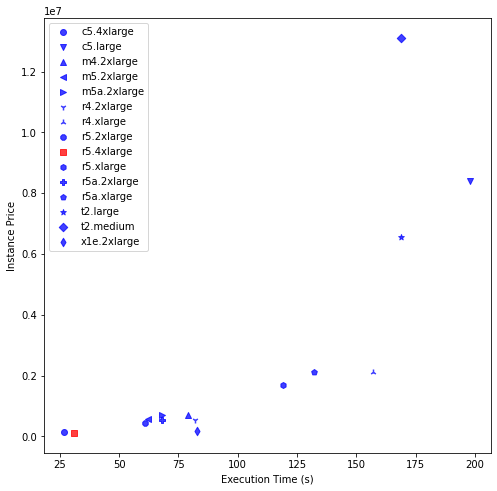

In [11]:
instances = sorted(perf_per_cost.keys())
costs = np.array([[perf_per_cost[i]] for i in instances])
paretto_colors = ["red"  if i==True else "blue" for i in is_pareto_efficient(costs)]
xs = [wall_time_per_flavor[i] for i in instances]
ys = [perf_per_cost[i] for i in instances]

markers = ["o", "v", "^", "<", ">", "1", "2", "8", "s", "h", "P", "p", "*", "D", "d"]*2
fig, ax = plt.subplots(figsize=(8, 8))

for label, x, y, marker, color in zip(instances, xs, ys, markers, paretto_colors):
    ax.scatter(x, y, label=label, marker=marker, c=color, alpha=0.75)
    
ax.set_xlabel("Execution Time (s)")
ax.set_ylabel("Instance Price")
ax.legend()
plt.show()